In [1]:
# --- set up environment

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

# for Set working folder, etc.
import os
import os.path

# for sampling 
import random

# set working folder
# fw slashes for windows
cwd_desired = "C:/Users/Bonita/Documents/work/velexi/neural networks" 
os.chdir(cwd_desired) 

# test code
# print(os.getcwd())

In [2]:
# --- etl spectrum files

# turn files into lists and cut off first line
# put into database "spectra"
# turn deleted points (flagged as -1.23e+34) into 0's


# init spectra and class databases
spectra_wd = str(cwd_desired + "/spectra2")
num_samples = len([name for name in os.listdir(spectra_wd) if \
                   os.path.isfile(os.path.join(spectra_wd,name))])
# test code 
print(num_samples)

spectrum_len = 480                                 # 480 >= the BECK spectrometer spectrum length
spectra = np.zeros((num_samples,spectrum_len))             
y = np.zeros((num_samples, 1))

# fill databases
i = 0

# find spectra folder
os.chdir(spectra_wd)

# etl the data
for filename in os.listdir(spectra_wd):
    file_object  = open(filename, 'r').readlines()
    # strip off header, add to matrix 'spectra'
    spectra[i,:] = file_object[1:]                  
    
    # label spectrum class, based on header
    # actinolite: 0, alunite: 1, calcite: 2
    material_name = file_object[0]
    
    # testcode
    # print(material_name)
    
    if material_name.find('Actinolite',)!= -1: #if material name contains actinolite
        y[i,0] = 0
    elif material_name.find('Alun',)!= -1:
        y[i,0] = 1
    else:                   #calcite
        y[i,0] = 2         
               
    # turn deleted points into 0
    for j in range(spectrum_len):  
        if spectra[i,j] <0:
            spectra[i,j]=0                          
    i+=1

# test code
# print(y[:])
# print(spectra[0:2,0])

32


In [3]:
# --- etl 

# divide up data randomly

# 80% training data 20% test for this pilot
# eventually, 60% training set, 20% validation set, 20% test set
sample_indices = list(range(0, num_samples))
train_set_size = 4*(num_samples//5)
test_set_size= num_samples-train_set_size
train_set_indices = random.sample(sample_indices,train_set_size)
test_set_indices = np.setdiff1d(sample_indices,train_set_indices)     #fixed bug: take remaining samples after making train set

# test code
# print(train_set_indices)
# print(test_set_indices)

# make train and test sets

train_set = spectra[train_set_indices, :]
train_labels = y[train_set_indices, :]
test_set = spectra[test_set_indices, :]
test_labels = y[test_set_indices, :]

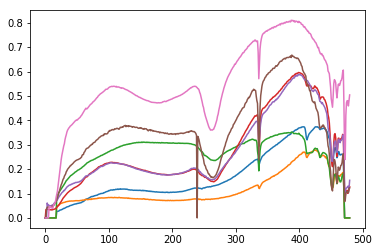

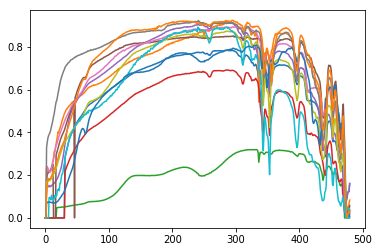

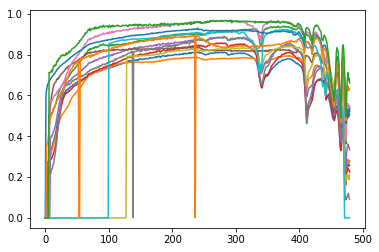

In [4]:
# --- graph the classes

num0 = 0 #number of samples of class 0
num1 = 0
num2 = 0

# count the number of each class to make spectra0, spectra1, spectra2 databases
for i in range(num_samples):
    if y[i,0]== 0:
        num0 += 1
    elif y[i,0]== 1:
        num1 += 1
    elif y[i,0]== 2:
        num2 += 1

# make class-specific databases spectra0, ...1, ...2
spectra0 = np.zeros((num0,spectrum_len)) 
spectra1 = np.zeros((num1,spectrum_len)) 
spectra2 = np.zeros((num2,spectrum_len)) 

# make counters for each database to place spectra
i0 = 0
i1 = 0
i2 = 0

# populate class-specific databases spectra0, ...1, ...2
for i in range(num_samples):
    if y[i,0]== 0:
        spectra0[i0,:] = spectra[i,:]
        i0 +=1
    elif y[i,0]== 1:
        spectra1[i1,:] = spectra[i,:]
        i1 +=1
    else:
        spectra2[i2,:] = spectra[i,:]
        i2 +=1

# plot each class-specific database separately
for i in range(i0):
    plt.plot(spectra0[i,:])
plt.figure()

for i in range(i1):
    plt.plot(spectra1[i,:])
plt.figure()

for i in range(i2):
    plt.plot(spectra2[i,:])

In [5]:
# --- Generate ICA spectra

# ICA Parameters
num_components = 25
# Create FastICA object
ica = FastICA(n_components=num_components)

# Fit ICA model
X = spectra
S_ = ica.fit_transform(X)
A_ = ica.mixing_  # Estimated independent components (mixing matrix)
print(X.shape)
print(S_.shape)
print(A_.shape)

#for i in range(A_.shape[1]):
#    plt.title('Component {}'.format(i))
#    plt.plot(A_[:,i])
#    plt.figure()

(32, 480)
(32, 25)
(480, 25)


In [6]:
# --- make plain nn model

model = keras.Sequential([
    keras.layers.Dense(300, activation=tf.nn.relu),
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

# compile
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train
model.fit(train_set, train_labels, epochs=15)

Epoch 1/15
24/24 [==============================] - 0s 14ms/step - loss: 1.6352 - acc: 0.1667
Epoch 2/15
24/24 [==============================] - 0s 209us/step - loss: 0.8994 - acc: 0.4167
Epoch 3/15
24/24 [==============================] - 0s 208us/step - loss: 0.8978 - acc: 0.4583
Epoch 4/15
24/24 [==============================] - 0s 250us/step - loss: 0.8768 - acc: 0.4583
Epoch 5/15
24/24 [==============================] - 0s 208us/step - loss: 0.8765 - acc: 0.7917
Epoch 6/15
24/24 [==============================] - 0s 209us/step - loss: 0.8444 - acc: 0.5000
Epoch 7/15
24/24 [==============================] - 0s 250us/step - loss: 0.8149 - acc: 0.4583
Epoch 8/15
24/24 [==============================] - 0s 167us/step - loss: 0.7700 - acc: 0.5833
Epoch 9/15
24/24 [==============================] - 0s 166us/step - loss: 0.7307 - acc: 0.7917
Epoch 10/15
24/24 [==============================] - 0s 125us/step - loss: 0.6928 - acc: 0.7917
Epoch 11/15
24/24 [==============================]

In [7]:
# --- test plain nn

test_loss, test_acc = model.evaluate(test_set, test_labels)

print('NN Test accuracy:', test_acc)

8/8 [==============================] - 0s 11ms/step
NN Test accuracy: 0.75


In [8]:
# --- transform train and test set into components

train_transformed = S_[train_set_indices, :]
test_transformed = S_[test_set_indices, :]
print(train_transformed.shape)
print(test_transformed.shape)

(24, 25)
(8, 25)


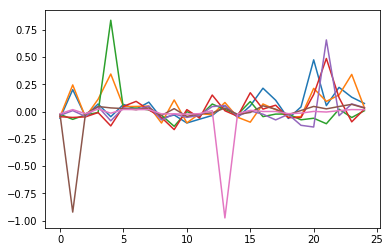

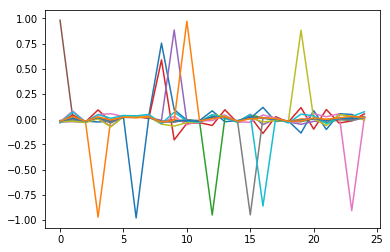

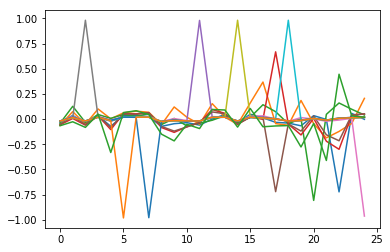

In [12]:
# --- visualize transformed spectra

# --- graph the classes

num0 = 0 #number of samples of class 0
num1 = 0
num2 = 0

# count the number of each class to make spectra0, spectra1, spectra2 databases
for i in range(num_samples):
    if y[i,0]== 0:
        num0 += 1
    elif y[i,0]== 1:
        num1 += 1
    elif y[i,0]== 2:
        num2 += 1

# make class-specific databases spectra0, ...1, ...2
icaspectra0 = np.zeros((num0, num_components)) 
icaspectra1 = np.zeros((num1, num_components)) 
icaspectra2 = np.zeros((num2, num_components)) 

# make counters for each database to place spectra
i0 = 0
i1 = 0
i2 = 0

# populate class-specific databases spectra0, ...1, ...2
for i in range(num_samples):
    if y[i,0]== 0:
        icaspectra0[i0,:] = S_[i,:]
        i0 +=1
    elif y[i,0]== 1:
        icaspectra1[i1,:] = S_[i,:]
        i1 +=1
    else:
        icaspectra2[i2,:] = S_[i,:]
        i2 +=1

# plot each class-specific database separately
for i in range(i0):
    plt.plot(icaspectra0[i,:])
plt.figure()

for i in range(i1):
    plt.plot(icaspectra1[i,:])
plt.figure()

for i in range(i2):
    plt.plot(icaspectra2[i,:])


In [9]:
# --- build NN on ICA model

model = keras.Sequential([
    keras.layers.Dense(100, activation=tf.nn.relu),
    keras.layers.Dense(3, activation=tf.nn.softmax)
])

# compile
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# train on ica
model.fit(train_transformed, train_labels, epochs=15)

Epoch 1/15
24/24 [==============================] - 0s 14ms/step - loss: 1.1383 - acc: 0.1667
Epoch 2/15
24/24 [==============================] - 0s 125us/step - loss: 1.1291 - acc: 0.1667
Epoch 3/15
24/24 [==============================] - 0s 167us/step - loss: 1.1200 - acc: 0.2083
Epoch 4/15
24/24 [==============================] - 0s 83us/step - loss: 1.1111 - acc: 0.3333
Epoch 5/15
24/24 [==============================] - 0s 125us/step - loss: 1.1023 - acc: 0.3333
Epoch 6/15
24/24 [==============================] - 0s 125us/step - loss: 1.0935 - acc: 0.3750
Epoch 7/15
24/24 [==============================] - 0s 167us/step - loss: 1.0849 - acc: 0.4583
Epoch 8/15
24/24 [==============================] - 0s 125us/step - loss: 1.0763 - acc: 0.5833
Epoch 9/15
24/24 [==============================] - 0s 125us/step - loss: 1.0679 - acc: 0.5833
Epoch 10/15
24/24 [==============================] - 0s 126us/step - loss: 1.0596 - acc: 0.5833
Epoch 11/15
24/24 [==============================] 

In [10]:
# --- test nn on ica

test_loss, test_acc = model.evaluate(test_transformed, test_labels)

print('NN Test accuracy:', test_acc)

8/8 [==============================] - 0s 12ms/step
NN Test accuracy: 0.375
